In [1]:
import os
os.chdir('Downloads/лаб3')

In [2]:
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
cifar10_dir = './'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


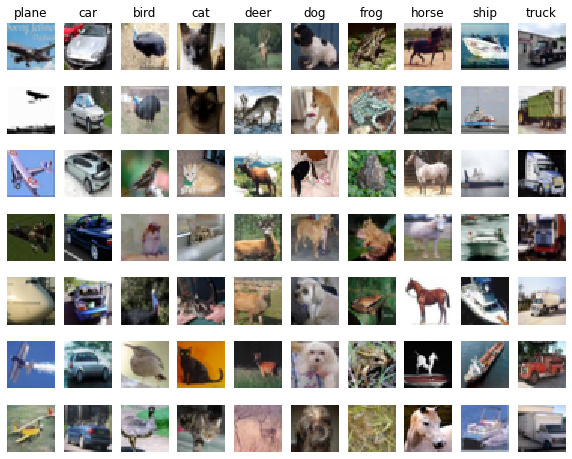

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3, 32, 32)
Validation data shape:  (1000, 3, 32, 32)
Test data shape:  (1000, 3, 32, 32)


In [8]:
X_train /= 255
X_val /= 255
X_test /= 255

train_mean = np.mean(X_train, axis=0)

X_train -= train_mean
X_val -= train_mean
X_val -= train_mean

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms


train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), 
                                               torch.from_numpy(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), 
                                             torch.from_numpy(y_val))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), 
                                              torch.from_numpy(y_test))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=10,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                         shuffle=False, num_workers=2)


In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=2)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

device = torch.device('cuda')
net.to(device)

for epoch in range(25):  # loop over the dataset multiple times
    
    net.train()
    running_loss = 0.0
    num_index = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        num_index += 10
    print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_index))
    
    net.eval()
    
    running_loss = 0.0
    num_index = 0
    for i, data in enumerate(valloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        num_index += 10
    print('[%d, %5d] validate loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_index))

            
print('Finished Training')

[1,  4900] training loss: 0.230
[1,   100] validate loss: 0.230
[2,  4900] training loss: 0.230
[2,   100] validate loss: 0.230
[3,  4900] training loss: 0.223
[3,   100] validate loss: 0.226
[4,  4900] training loss: 0.174
[4,   100] validate loss: 0.184
[5,  4900] training loss: 0.147
[5,   100] validate loss: 0.164
[6,  4900] training loss: 0.123
[6,   100] validate loss: 0.131
[7,  4900] training loss: 0.101
[7,   100] validate loss: 0.123
[8,  4900] training loss: 0.085
[8,   100] validate loss: 0.142
[9,  4900] training loss: 0.072
[9,   100] validate loss: 0.097
[10,  4900] training loss: 0.061
[10,   100] validate loss: 0.104
[11,  4900] training loss: 0.050
[11,   100] validate loss: 0.116
[12,  4900] training loss: 0.040
[12,   100] validate loss: 0.113
[13,  4900] training loss: 0.031
[13,   100] validate loss: 0.129
[14,  4900] training loss: 0.023
[14,   100] validate loss: 0.138


KeyboardInterrupt: 

Доля верных ответов 0.734


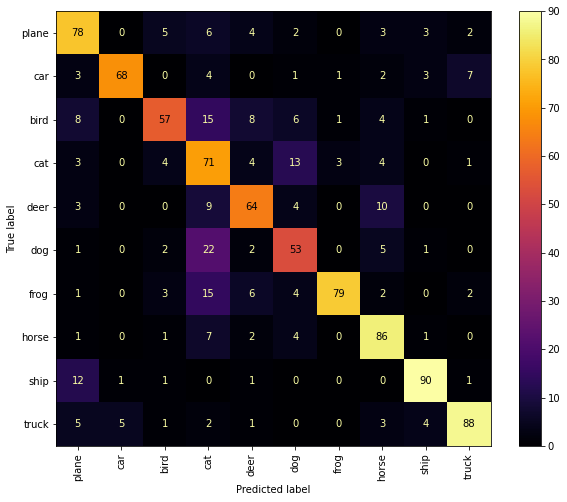

In [15]:
test_inputs, test_labels = torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_test).to(device)
test_pred = net(test_inputs)

test_loss = F.cross_entropy(test_pred,
                            test_labels)

print('Доля верных ответов', accuracy_score(test_labels.cpu().numpy(), 
                                            test_pred.argmax(-1).cpu().numpy()))

conf = confusion_matrix(y_true=test_labels.cpu().numpy(), y_pred=test_pred.argmax(-1).cpu().numpy())                      
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=classes).plot(cmap ='inferno', xticks_rotation='vertical')
plt.show()